# Data Challenge 12 — Intro to Logistic Regression

**Hook (Attention Grabber)**  
> “If an app told a restaurant it has an 80% chance of getting an **A** on inspection, would you trust it?”

**Learning Goals**
- Show why **linear regression** is a bad fit for a **binary (0/1)** target.
- Fit a **one-feature logistic regression** and interpret probabilities.
- Extend to a **two-feature logistic model with standardized inputs**.
- Communicate results using **AWES** and discuss **ethics & people impact**.

**Data:** June 1, 2025 - Nov 4, 2025 Restaurant Health Inspection

[Restaurant Health Inspection](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- LinearRegression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- LogisticRegression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- StandardScaler — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- accuracy_score — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
- corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Linear vs Logistic + Scaling)
1) **Load CSV** → preview shape/columns; keep needed fields.  
2) **Engineer binary Y**: `is_A = 1 if grade == 'A' else 0`.  
3) **Pick numeric X**:  
   - **X1:** `score` (inspection score; lower is better)  
   - **X2:** `critical_num = 1 if critical_flag == 'Critical' else 0` (for extension)  
4) **Split** → `X_train, X_test, y_train, y_test` (70/30, stratify by Y, fixed random_state).  
5) **Model A (Incorrect)** → **LinearRegression** on Y~X1:  
   - Report **MSE**, **R²**, count predictions **<0 or >1**,  
6) **Model B (Correct)** → **LogisticRegression** on Y~X1:  
   - Report **Accuracy**
7) **Visual (OPTIONAL)** → scatter Y vs X1 with **linear line** vs **logistic sigmoid** curve  
8) **Extension** → scale X1+X2 with **StandardScaler**; fit **LogisticRegression**:  
   - Compare **Accuracy** to one-feature logistic  
9) **Interpret** → 2–3 sentences on why linear fails and how logistic fixes it  


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

## Context about this dataset
- It’s data from the NYC Department of Health about restaurant inspections across New York City. Each row represents a single violation or inspection event for a restaurant or college cafeteria.

This dataset is lowkey tricky because 
- One restaurant can appear in multiple rows (because of multiple violations).
- Some inspections don’t count toward grading (like calorie labeling or smoke-free checks).
- Data sometimes has inconsistencies or missing values.

## Step 1 — Imports and Plot Defaults

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Step 2 — Load CSV & Preview
- Point to your New York City Restaurant Inspection Data 

In [63]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104 copy.csv')

## Step 3 — Clean and Engineer Features
- Make sure `SCORE` is numeric and do any other data type clean-up 
- Engineer binary target variable (Y) based on instructor guidance above `is_A`
- Engineer binary predictor (X) based on instructor guidance above `critical_num`


Note to self:
- is_A is my y
- score and critical_num are my features (X)

My goal:  Given a restaurant’s inspection score, what’s the probability it gets an A grade?
- SCORE: A numeric column showing total violation points (lower = better).
    - It’s continuous, so it helps the model see patterns like: “If score < 13,  more likely to get an A.”
- critical_num
    - A binary column created from CRITICAL FLAG.
    - 1 means the restaurant had a critical violation, 0 means no critical violation.
    - It adds extra context, since having a critical violation might reduce the chance of an A.

In [64]:
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location
0,50174196,THE GREATS OF CRAFT,Queens,47-20,CENTER BOULEVARD,11109.0,3479312023,NaN,01/01/1900,NaN,...,NaN,40.745641,-73.957137,402.0,26.0,100.0,4538318.0,4.000210e+09,QN31,POINT (-73.957136627525 40.745640668157)
1,50140563,CANTEEN @ CHELSEA PIERS FIELD HOUSE,Brooklyn,601,DEAN STREET,11238.0,6313880993,NaN,01/01/1900,NaN,...,NaN,40.680616,-73.969992,308.0,35.0,16300.0,3428601.0,3.000000e+09,BK64,POINT (-73.969992200023 40.68061568349)
2,50177123,70 7TH AVENUE SOUTH THEROS LLC,Queens,3009,35TH ST,11103.0,6468076482,NaN,01/01/1900,NaN,...,NaN,40.764778,-73.918674,401.0,22.0,6300.0,4009926.0,4.006500e+09,QN70,POINT (-73.918674354617 40.764778282908)
3,50001285,Y & B ENTERTAINMENT MANOR,Queens,3509,PRINCE STRRET,NaN,7188881778,Korean,06/24/2018,Violations were cited in the following area(s).,...,Smoke-Free Air Act / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN
4,50172517,MAPLE CREAMERY,Brooklyn,653,STERLING PLACE,11216.0,7188095106,NaN,01/01/1900,NaN,...,NaN,40.673255,-73.956830,308.0,35.0,21900.0,3031390.0,3.012380e+09,BK61,POINT (-73.956830036833 40.673255481805)


In [65]:
df.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
Latitude                 float64
Longitude                float64
Community Board          float64
Council District         float64
Census Tract             float64
BIN                      float64
BBL                      float64
NTA                       object
Location                  object
dtype: object

In [66]:
df.keys()

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location'],
      dtype='object')

In [67]:
df.shape

(291278, 27)

In [68]:
df.isnull().sum()

CAMIS                         0
DBA                           4
BORO                          0
BUILDING                    850
STREET                       11
ZIPCODE                    3109
PHONE                         7
CUISINE DESCRIPTION        3898
INSPECTION DATE               0
ACTION                     3898
VIOLATION CODE             6200
VIOLATION DESCRIPTION      6200
CRITICAL FLAG                 0
SCORE                     16339
GRADE                    149068
GRADE DATE               156781
RECORD DATE                   0
INSPECTION TYPE            3898
Latitude                    524
Longitude                   524
Community Board            4065
Council District           4057
Census Tract               4057
BIN                        5517
BBL                        1126
NTA                        4065
Location                   3463
dtype: int64

In [69]:
# make score numeric
df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')

In [70]:
df[['SCORE', 'GRADE']].tail(20)

,SCORE,GRADE
291258,7.0,A
291259,12.0,A
291260,28.0,NaN
291261,18.0,NaN
291262,13.0,A
291263,35.0,NaN
291264,23.0,B
291265,27.0,N
291266,89.0,NaN
291267,63.0,NaN


In [71]:
# INSPECTION DATE == 01/01/1900, BE GONE ROWS!!!
# Any rows where SCORE or GRADE is missing, drop those, since you can’t model with em 
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'], errors='coerce')
df_cleaned = df[df['INSPECTION DATE'] != '01/01/1900'].dropna(subset=['SCORE'])

In [72]:
df_cleaned['GRADE'].isna().sum()


132745

In [73]:
df['SCORE'].unique()[:20]


array([nan, 13.,  0.,  9., 34., 22., 10., 16., 44., 31., 27., 62., 11.,
       53.,  4., 23., 28., 24., 26., 17.])

#### Context
I got these scores based on the documentation from the pdf provided on the datasets website

- A score of less than 14 points on either initial or re-inspection results in an ‘A’ grade.
- A score of 14–27 points means a restaurant receives a ‘B’ grade
- A score of 28 or more points means a restaurant receives a ‘C’ grade.

In [74]:
# I am going to impute grade by creating a function that assigns a grade based on score
def assign_grade(score):
    # if score is NaN, leave it as is
    if pd.isna(score):
        return np.nan
    # grade A
    elif score <= 13:
        return 'A'
    #grade b
    elif score >=14 and score <=27:
        return 'B'
    # grade c
    else:
        return 'C'


In [75]:
# apply the function to the SCORE column to create a new GRADE column
df_cleaned['GRADE'] = df_cleaned['GRADE'].fillna(df_cleaned['SCORE'].apply(assign_grade))
df_cleaned['GRADE'].isna().sum()

0

In [76]:
df_cleaned['INSPECTION DATE'].min()

Timestamp('2015-09-24 00:00:00')

In [77]:
df_cleaned['GRADE'].value_counts()

GRADE
A    105591
C     87519
B     66929
N      7702
Z      6280
P       918
Name: count, dtype: int64

In [78]:
# I am going to only include grades a b c for this model
df = df_cleaned[df_cleaned['GRADE'].isin(['A', 'B', 'C'])]

In [79]:
df['GRADE'].value_counts()

GRADE
A    105591
C     87519
B     66929
Name: count, dtype: int64

In [80]:
# Engineer binary target variable (Y) based on instructor guidance above `is_A`
df['is_A'] = df['GRADE'].apply(lambda g: 1 if g== 'A' else 0)

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_43591/119442739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_A'] = df['GRADE'].apply(lambda g: 1 if g== 'A' else 0)


In [81]:
df['is_A'].value_counts(normalize=True)

is_A
0    0.593942
1    0.406058
Name: proportion, dtype: float64

In [82]:
# Engineer your binary predictor critical_num
df['critical_num'] = df['CRITICAL FLAG'].apply(lambda x: 1 if x == 'Critical' else 0)

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_43591/1705856296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['critical_num'] = df['CRITICAL FLAG'].apply(lambda x: 1 if x == 'Critical' else 0)


In [83]:
print(df['critical_num'].value_counts())
print(df['critical_num'].value_counts(normalize=True))


critical_num
1    145612
0    114427
Name: count, dtype: int64
critical_num
1    0.559962
0    0.440038
Name: proportion, dtype: float64


## Step 4 — Split Data (70/30 Stratify by Target)

note to self:
- We need to strtify because is_A is not perfectly balanced, if I split randomly, I could end up with uneven proportions in the training vs test set. Hence, using stratify = y makes sure its fair for training and testing

In [84]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_A, dtype: int64

In [85]:
X.head()

,SCORE,critical_num
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0


In [86]:
print(X.shape)
print(y.shape)

(291278, 2)
(291278,)


In [87]:
# set my x and y
X = df[['SCORE', 'critical_num']]
y = df['is_A']

In [88]:
# split my data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42, stratify=y)

## Step 5 — Model A: Linear Regression on a Binary Target (Incorrect)

- Fit `is_A (Y var) ~ SCORE (X pred)` using **LinearRegression**  
- Report **MSE**, **R²**, and how many predictions fall outside [0, 1]  
- Estimate accuracy by thresholding predictions at 0.5 (done for you but understand the code) 

💡 Hint:  
`accuracy_score(y_test, (y_pred >= 0.5).astype(int))`

### note to self about the .5 cutoff

what the 0.5 cutoff means:
- When you use linear regression on a binary outcome (like yes/no or A/not A), it gives you continuous predictions... numbers like 0.2, 0.7, 1.4, -0.3.
- But in classification problems, you need to turn those predictions into actual classes (0 or 1).

So we use a cutoff (threshold):
- If the prediction is >= 0.5, we label it as 1 (“A”).
- If the prediction is < 0.5, we label it as 0 (“not A”).
    - That’s what y_pred >= 0.5 does, it forced the continuous outputs from the linear model into binary categories.

This is a problem because: 
- Linear regression doesn’t understand that probabilities should stay between 0 and 1, so:
    - It can predict negative values or numbers greater than 1, which makes no sense for probability.
    - The “.5 cutoff” is just a band-aid fix to make it act like a classifier, but it’s not mathematically correct.
    - The high accuracy result looked impressive, but it wasn’t trustworthy since it came from a poor model setup, not real probability logic.

How to connect this to classification:
- Classification models (like logistic regression) are built to handle binary outcomes.
- They predict probabilities between 0 and 1 using the sigmoid curve, so the outputs always make sense as “chances” of being 1 

In [89]:
#fit the model
modelA = LogisticRegression()
modelA.fit(X_train[['SCORE']], y_train)

LogisticRegression()

In [90]:
# make predictions
y_pred = modelA.predict(X_test[['SCORE']])

In [91]:
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")


MSE: 0.0074
R²: 0.9693


In [92]:
((y_pred < 0) | (y_pred > 1)).sum()

0

In [93]:
accuracy_score(y_test, (y_pred >= 0.5).astype(int))

0.9925908834538276

In [94]:
df['is_A'].value_counts(normalize=True)

is_A
0    0.593942
1    0.406058
Name: proportion, dtype: float64

### Note to self - breakdown (because my brain doesn't get this fully yet)
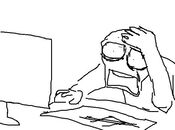


- So I used Linear Regression to predict whether a restaurant gets an A grade or not (is_A = 1 or 0).
1. First I checked if there any predictions less 0 or greather than 1
2. Then I checked how accurate it was

My results: 
- Out-of-range predictions: 0
- Accuracy: 0.9925 = 99.25%
    - At first glance, 99% accuracy looked amazing but then but I then brought myself back to reality 

Remember:
- When I made my binary variable is_A, about 40% of restaurants were A’s (1s), and 60% were not A’s (0s).
- When I imputed missing grades using the score mapping (A: 0–13, B: 14–27, C: 28+), I filled in a lot of grades that were missing and many of those missing ones probably had higher scores (since they hadn’t been graded yet or had violations).
    - That means more rows got labeled as B or C, lowering the percentage of A’s.
    - So my imputation shifted the balance toward more non-A restaurants, which makes sense.

What linear regression is doing here:
- Linear regression is built for continuous data (like predicting prices or time). When you force it to predict a binary variable (0 or 1):
    - It just draws a straight line through your points. That line might land between 0 and 1 most of the time (which is fine mathematically).
    - But those numbers don’t actually mean “probabilities.”
    - The model doesn’t really understand the idea of “yes vs no.”
    - So when you then say “anything above 0.5 = yes (A), anything below = no,” you’re just turning that straight line into fake probabilities.
    - That’s why the accuracy number looks nice but it’s not trustworthy, because the model **isn’t** built for this kind of task.

### Insight
- 0 out-of-range values: still not ideal for binary prediction.
- 99% accuracy: Misleading because the data is imbalanced, linear regression just guessed the majority correctly.
- Low MSE = predictions close to actuals 
- Next step (Logistic Regression): fit a model that outputs probabilities between 0 and 1 properly and handles classification mathematically correctly.

The model looks “great” on paper (high accuracy, low error, high R²), but it’s misleading... linear regression isn’t meant for yes/no outcomes. It doesn’t give probabilities, it doesn’t understand classification, and it only got lucky (I think) that the data happened to line up nicely.

## Step 6 — Model B: Logistic Regression (One Feature)

- Fit `is_A ~ score` using **LogisticRegression**  
- Compute predictions with `.predict()`  
- Evaluate accuracy with `accuracy_score()`

In [95]:
# now lets fit a logistic regression model
modelB = LogisticRegression()
modelB.fit(X_train[['SCORE']], y_train)
y_pred_logistic = modelB.predict(X_test[['SCORE']])
accuracy_score(y_test, y_pred_logistic)

0.9925908834538276

In [96]:
proba_df = pd.DataFrame(
    modelB.predict_proba(X_test[['SCORE']]),
    columns=['Prob_not_A', 'Prob_A']
)
proba_df.head(10)


,Prob_not_A,Prob_A
0,0.000097,9.999031e-01
1,1.000000,5.019050e-12
2,1.000000,7.730187e-10
3,1.000000,2.325724e-35
4,0.999982,1.833660e-05
5,1.000000,1.373777e-18
6,1.000000,7.730187e-10
7,1.000000,2.015582e-24
8,0.000003,9.999966e-01
9,0.000003,9.999966e-01


I fear 'score' is actually a strong predictor of 'is_A' 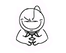


The key difference: logistic regression’s accuracy is trustworthy, unlike the linear model’s

## Step 7 (OPTIONAL) — Visual Comparison: Linear vs Logistic


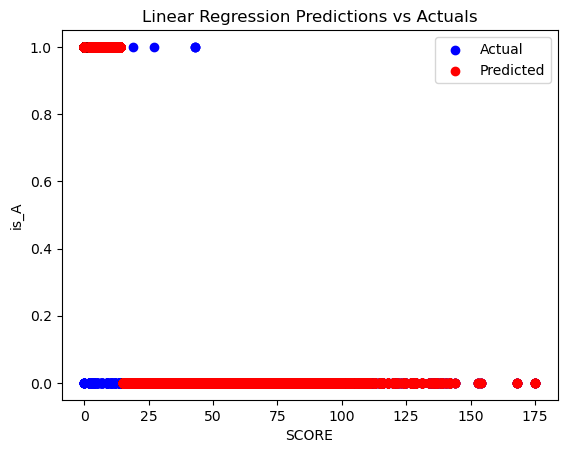

In [97]:
# Visual of linear regression predictions
import matplotlib.pyplot as plt
plt.scatter(X_test['SCORE'], y_test, color='blue', label='Actual')
plt.scatter(X_test['SCORE'], y_pred, color='red', label='Predicted')
plt.xlabel('SCORE')
plt.ylabel('is_A')
plt.title('Linear Regression Predictions vs Actuals')
plt.legend()
plt.show()

my reaction when I saw this: 
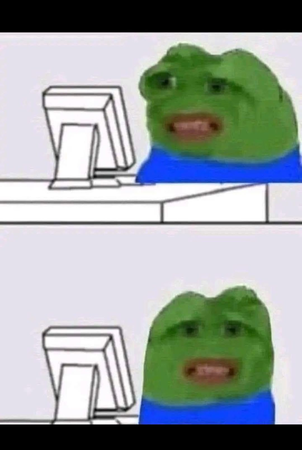

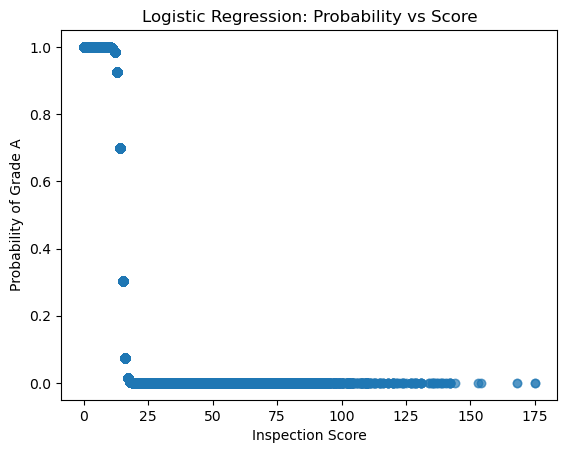

In [98]:
plt.scatter(X_test['SCORE'], proba_df['Prob_A'], alpha=0.3)
plt.xlabel('Inspection Score')
plt.ylabel('Probability of Grade A')
plt.title('Logistic Regression: Probability vs Score')
plt.show()


Much better! This makes so much more sense because:
- Look at the left side of the graph (low inspection scores, near 0–15): You see points near 1.0 on the y-axis 
    - the model is very confident these are “A” grades.
- As you move right (higher scores, say 25–40): The points drop sharply toward 0 
    - the model is very confident these are not A’s.
- Past about 30–35, the probability completely bottoms out near 0 
    - those are clearly failing inspections (B’s and C’s).

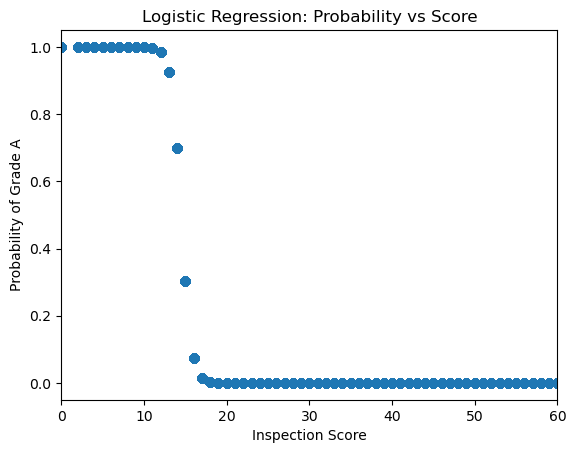

In [99]:
plt.scatter(X_test['SCORE'], proba_df['Prob_A'], alpha=0.3)
plt.xlabel('Inspection Score')
plt.ylabel('Probability of Grade A')
plt.title('Logistic Regression: Probability vs Score')

# zoom in! 
plt.xlim(0, 60)     # shows scores only from 0 to 60
plt.show()


## Step 8 — Logistic Regression with Two **Scaled** Features

- Use `SCORE` and `critical_num` as your two X predictors that need to be scaled
- Look at documentation above to see how you would fit a StandardScalar() object 


In [100]:
modelC = LogisticRegression()
modelC.fit(X_train[['SCORE', 'critical_num']], y_train)
y_pred_logistic = modelC.predict(X_test[['SCORE', 'critical_num']])
accuracy_score(y_test, y_pred_logistic)

0.9925908834538276

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['SCORE', 'critical_num']])
X_test_scaled = scaler.transform(X_test[['SCORE', 'critical_num']])

### Scaling note
- Scale when your features are on very different ranges , esp when you think about the fairness and stability of coefficients.
- Skip scaling when your data is already simple (like one numeric and one binary feature) 

# We Share — Reflection & Wrap-Up

Write **two short paragraphs** (4–6 sentences each). Be specific and use evidence from your notebook.

1️⃣ **How do you know Linear Regression was a poor model choice for this task?**  
Describe what you observed in your results or plots that showed it didn’t work well for a binary outcome.  
Consider: Were predictions outside 0–1? Did the fit look wrong? What happened when you used 0.5 as a cutoff?  
Connect this to the idea that classification models should output probabilities between 0 and 1.

- Linear Regression wasn’t a good model for this task because it’s designed for predicting continuous values, not binary outcomes. Even though it gave high accuracy and a strong R², those metrics were misleading. The model was trying to fit a straight line through yes/no data. It also required me to use a 0.5 cutoff to force predictions into 0 or 1, which is a workaround that doesn’t reflect real probabilities. Classification models like Logistic Regression are more appropriate because they output probabilities between 0 and 1, which can be interpreted as the likelihood of a restaurant getting an A grade.


2️⃣ **When should we scale features in logistic regression (and when not to)?**  
Explain what scaling does, and why it might (or might not) matter for different kinds of features.  
Use this project to reason through whether `score` and `critical_num` needed scaling.  
Hint: Think about what “continuous” vs “binary” means for scaling decisions.

- Scaling in this context is used when your features are measured in different ranges or units, it helps make sure they’re being compared fairly by the model. You’re not changing the actual values themselves, just the way they’re measured so everything is on the same scale. For example, if you’re working with a more complex model that has many continuous features (like income, age, and height), scaling can make it easier to interpret and stabilize the model’s learning process.
- It’s not always necessary though. In this data challenge, SCORE and critical_num didn’t really need to be scaled because they were already easy to understand and didn’t vary wildly in scale. SCORE is just a numeric measure of violations, and critical_num is binary (0 or 1), which is already simple and consistent. So while scaling is great for continuous features that are on very different scales, it’s not really needed for binary ones or small, straightforward datasets like this.